In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("clean_data.csv")
data.head()

,gameId,season,gameType,gameDate,homeTeam,awayTeam,period,periodTime,byTeam,eventType,shotType,coordinateX,coordinateY,shooterName,goalieName,strength,emptyNet
0,2016020001,2016,R,2016-10-12,OTT,TOR,1,01:11,TOR,SHOT,Wrist Shot,-77.0,5.0,Mitchell Marner,Craig Anderson,False,False
1,2016020001,2016,R,2016-10-12,OTT,TOR,1,02:53,OTT,SHOT,Wrist Shot,86.0,13.0,Chris Kelly,Frederik Andersen,False,False
2,2016020001,2016,R,2016-10-12,OTT,TOR,1,04:01,OTT,SHOT,Wrist Shot,23.0,-38.0,Cody Ceci,Frederik Andersen,False,False
3,2016020001,2016,R,2016-10-12,OTT,TOR,1,04:46,OTT,SHOT,Slap Shot,33.0,-15.0,Erik Karlsson,Frederik Andersen,False,False
4,2016020001,2016,R,2016-10-12,OTT,TOR,1,06:46,TOR,SHOT,Wrist Shot,-34.0,28.0,Martin Marincin,Craig Anderson,False,False


# Comparaison des types de tirs: Total de tirs vs Buts

In [2]:
# Filtering for the shots and goals events
shots_data = data[data['season'] == 2020]

# Grouping by shotType and counting the number of shots and goals
shot_counts = shots_data.groupby('shotType').eventType.value_counts().unstack().fillna(0)

# Sorting by total shots for better visualization
shot_counts['TotalShots'] = shot_counts['SHOT'] + shot_counts['GOAL']
shot_counts = shot_counts.sort_values(by='TotalShots', ascending=False)

# Calculating the percentage of shots that are goals
shot_counts['GoalPercentage'] = (shot_counts['GOAL'] / shot_counts['TotalShots']) * 100

shot_counts

eventType,GOAL,SHOT,TotalShots,GoalPercentage
shotType,,,,
Wrist Shot,2998,29973,32971,9.092839
Slap Shot,560,7422,7982,7.015786
Snap Shot,812,6988,7800,10.410256
Backhand,538,3915,4453,12.081743
Tip-In,504,2293,2797,18.019306
Deflected,182,986,1168,15.582192
Wrap-around,38,521,559,6.797853


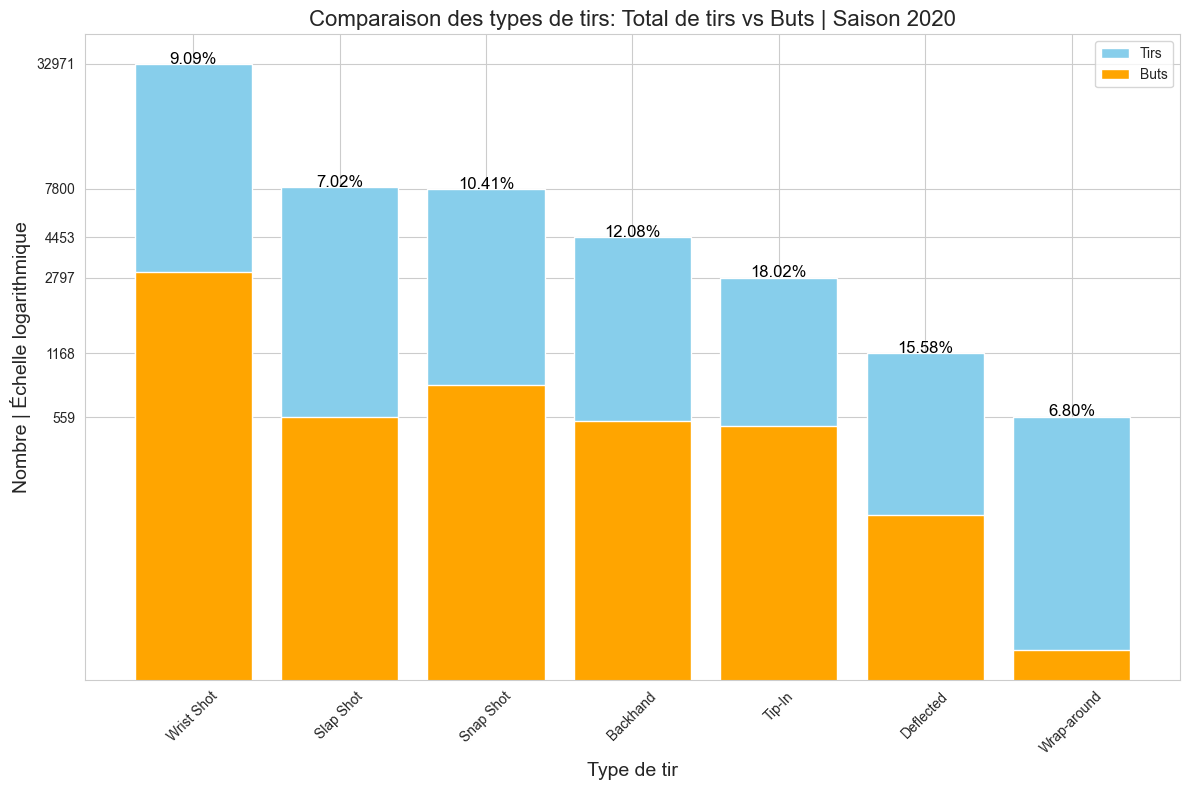

In [3]:
# Setting up the plot
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Plotting total shots
bars = plt.bar(shot_counts.index, shot_counts['TotalShots'], label='Tirs', color='skyblue')

# Plotting goals
plt.bar(shot_counts.index, shot_counts['GOAL'], label='Buts', color='orange')

# Adding the percentage above each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2,  # Centering the percentage in the middle of the bin
             bar.get_height() + 10,  # Adjusting the position to be above the bin
             f"{shot_counts['GoalPercentage'].iloc[i]:.2f}%",
             ha='center', color='black', fontsize=12) 

# Adding labels, title, and legend in French
plt.ylabel('Nombre | Échelle logarithmique', fontsize=14)
plt.xlabel('Type de tir', fontsize=14)
plt.yscale('log')
plt.yticks(shot_counts['TotalShots'].drop('Slap Shot'), shot_counts['TotalShots'].drop('Slap Shot'))
plt.title('Comparaison des types de tirs: Total de tirs vs Buts | Saison 2020', fontsize=16)
plt.legend()
plt.xticks(rotation=45)

# Displaying the plot
plt.tight_layout()
plt.show()

Lorsque nous examinons le graphique présentant une comparaison entre le nombre total de tirs (en bleu) et le nombre de buts (en orange) pour différents types de tirs lors de la saison 2020, plusieurs points clés ressortent. Tout d'abord, le "Wrist Shot" se distingue comme le type de tir le plus courant, affichant le plus grand nombre de tentatives. C'est probablement dû au fait que le "Wrist Shot" est un tir fondamental dans le monde du hockey, privilégié pour sa rapidité de déclenchement et sa précision. Cependant, si l'on évalue la dangerosité d'un tir en fonction du rapport entre le nombre de buts marqués et le nombre total de tirs, le "Tip In" se révèle être le plus efficace, avec un taux de conversion impressionnant de 18,02%. La nature imprévisible de ces tirs déviés à la dernière seconde pourrait expliquer pourquoi ils sont si redoutables pour les gardiens de but.

Quant au choix du graphique à barres superposées, il s'est avéré être particulièrement éclairant. Il offre une comparaison directe et visuellement claire, renforcée par l'utilisation de couleurs distinctes pour les tirs et les buts. L'échelle logarithmique, quant à elle, est efficace pour mettre en évidence les différences, même pour les types de tirs qui ont un nombre plus faible de tentatives et de buts.

# Relation entre la distance à laquelle un tir a été effectué et la chance qu'il s'agisse d'un but

In [4]:
import numpy as np

def adjust_coordinates(x, y):
    if x < 0:
        return -x, -y
    return x, y

adjustedCoordinates = np.array(data.apply(lambda row: adjust_coordinates(row['coordinateX'], row['coordinateY']), axis=1).tolist())

In [20]:
goal_position = [89, 0]

data["distance"] = np.sqrt(np.sum(np.square(adjustedCoordinates - goal_position), axis=1))

In [55]:
import numpy as np
import pandas as pd

# Assuming you've loaded your data into 'data' DataFrame

# Filter the data for the specified seasons
seasons_data = data[data['season'].isin([2018, 2019, 2020])]

# Define bin edges for distance
bin_edges = np.linspace(0, 100, 21)  # bins of width 5 from 0 to 100

# Calculate goal probabilities for each season
seasons = [2018, 2019, 2020]
goal_probabilities = {}

for season in seasons:
    # Make an explicit copy of the subset
    season_data = seasons_data[seasons_data['season'] == season].copy()
    
    # Bin the shot distances
    season_data.loc[:, 'distance_bin'] = pd.cut(season_data['distance'], bins=bin_edges)
    
    # Calculate goal probabilities for each bin
    goal_prob = season_data.groupby('distance_bin', observed=True).apply(lambda x: (x['eventType'] == 'GOAL').sum() / len(x))
    goal_probabilities[season] = goal_prob

goal_probabilities[2018]

distance_bin
(0.0, 5.0]       0.296203
(5.0, 10.0]      0.185227
(10.0, 15.0]     0.166811
(15.0, 20.0]     0.152603
(20.0, 25.0]     0.124268
(25.0, 30.0]     0.112798
(30.0, 35.0]     0.085201
(35.0, 40.0]     0.061899
(40.0, 45.0]     0.046965
(45.0, 50.0]     0.039062
(50.0, 55.0]     0.033411
(55.0, 60.0]     0.031133
(60.0, 65.0]     0.026962
(65.0, 70.0]     0.023753
(70.0, 75.0]     0.027508
(75.0, 80.0]     0.036244
(80.0, 85.0]     0.032626
(85.0, 90.0]     0.030201
(90.0, 95.0]     0.051282
(95.0, 100.0]    0.000000
dtype: float64

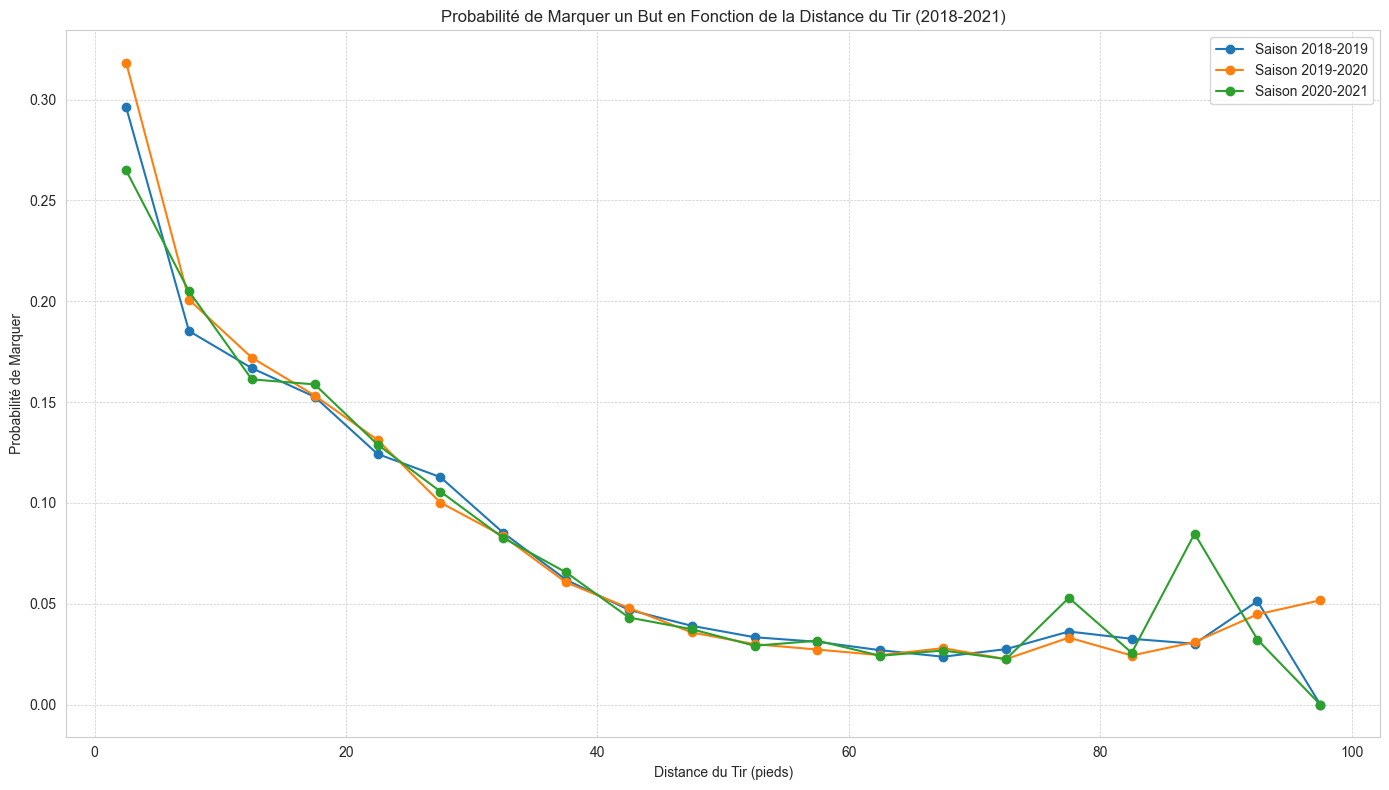

In [50]:
# Plotting the goal probabilities for each season with French labels and title
plt.figure(figsize=(14, 8))

for season, probs in goal_probabilities.items():
    plt.plot(probs.index.categories.mid, probs, label=f'Saison {season}-{season+1}', marker='o')

plt.title('Probabilité de Marquer un But en Fonction de la Distance du Tir (2018-2021)')
plt.xlabel('Distance du Tir (pieds)')
plt.ylabel('Probabilité de Marquer')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

De manière générale, on observe que plus la distance du tir est grande, plus la probabilité de marquer un but est faible. C'est une observation logique car il est naturellement plus difficile de marquer depuis une position éloignée. Les tirs effectués à très courte distance (0-5m) présentent la plus haute probabilité de se transformer en but, souvent supérieure à 25%. Cette probabilité décroît assez régulièrement jusqu'à une distance d'environ 40m. Au-delà de cette distance, elle semble fluctuer davantage, possiblement à cause d'un nombre d'échantillons moins important pour les tirs longue distance, rendant les probabilités moins stables. Les trois saisons montrent des tendances assez similaires avec cependant de légères variations. Par exemple, la saison 2019-20 semble avoir une probabilité légèrement plus élevée de marquer à très courte distance comparativement aux deux autres saisons.